# Can Age and Hours of MineCraft Played Predict Experience of Players?

## Introduction

##### Background
MineCraft is a well-known video game created in 2009 by Mojang Studios. The game entails a full block-based 3D world for players to explore and customize. Playable on almost any device, MineCraft is still enjoyed by millions of people of all ages. Our data consists of the ages, gaming hours and experience of about 200 players. Gaming experience is ranked from best to worst as Veteran, Pro, Regular, Amateur, and Beginner. 
##### Question
The question I will attempt to answer is whether the ages and play time of MineCraft players can predict their gaming experience, and if so, how?
##### Data Description
For this project, I will use one main dataset, called players.csv. This is a list of all unique players, including data about each player. The data not only includes ages and gaming experience, but:
- names
- genders
- hashed emails
- newsletters subscriptions
- hours played!

## Methods and Results

First we need to download the library packages.

In [114]:
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)

Then, the data is read/loaded in as a data frame using the read_csv function.

In [115]:
players=read_csv(file= "players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


I will be treating `experience` as a categorical variable, so I should convert it into a factor using the `as_factor()` function.

In [126]:
players <- players |>
        mutate(experience = as_factor(experience))
players

experience,played_hours,Age,Class
<fct>,<dbl>,<dbl>,<fct>
Pro,30.3,9,Pro
Veteran,3.8,17,Veteran
Veteran,0.0,17,Veteran
⋮,⋮,⋮,⋮
Veteran,0.3,22,Veteran
Amateur,0.0,17,Amateur
Amateur,2.3,17,Amateur


I will also remove all variables that are not relevant for our investigation!

In [127]:
players=select(players, experience, played_hours, Age)|>
filter(!is.na(Age))
players

experience,played_hours,Age
<fct>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
⋮,⋮,⋮
Veteran,0.3,22
Amateur,0.0,17
Amateur,2.3,17


Now, we can create a scatterplot with hours played on the y-axis and age on the x-axis.

Warning message:
“Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`).”


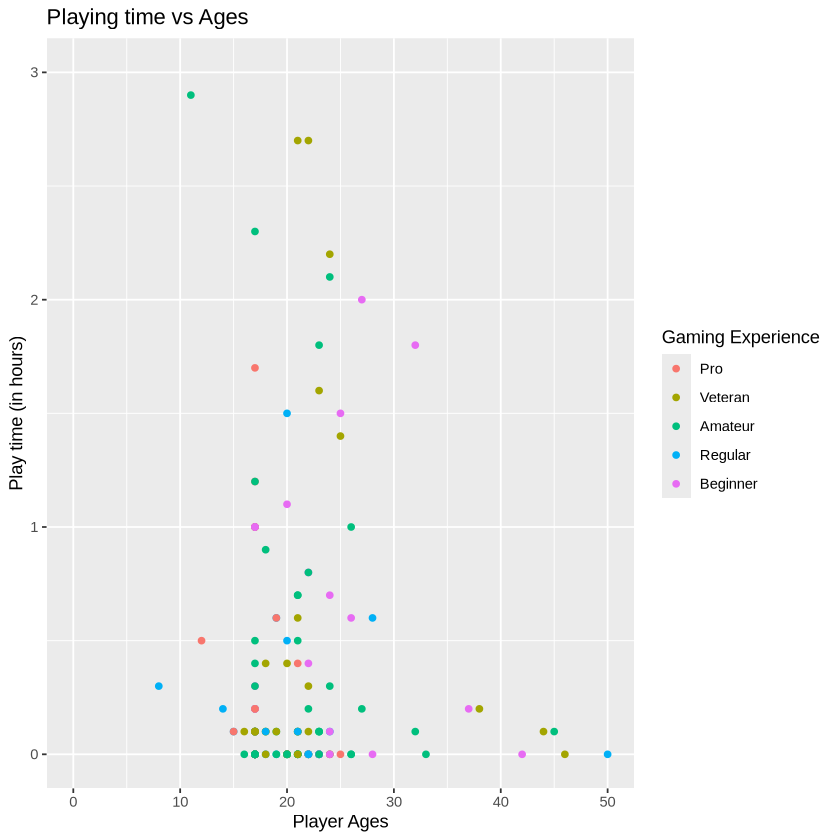

In [128]:
player_plot=players |>
ggplot(aes(x=Age, y=played_hours, colour=experience)) +
geom_point() +
xlab("Player Ages") +
ylab("Play time (in hours)") +
labs(color="Gaming Experience")+
ylim(0,3)+
xlim(0,50)+
ggtitle("Playing time vs Ages")
player_plot

The above data gives a rough idea that so far, it is quite difficult to use ages and play time to predict gaming experience given the scattered points, but let's see if we can use the classification model to predict the data! However, I need to first split the players data into a training (75%) and testing (25%) set using the tidymodels package.

In [129]:
set.seed(2026) 
players_split <- initial_split(players, prop = 0.75, strata = experience)  
players_train <- training(players_split)   
players_test <- testing(players_split)

Now, let's try using K=3 to make the model.

In [130]:
set.seed(2026) 
play_spec <- nearest_neighbor(weight_func = "rectangular", neighbors=3) |>
       set_engine("kknn") |>
       set_mode("classification")
play_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


Above, I created the model using the nearest_neighbor function, and the tune() function is used since we don't yet know what an optimal k would be. I set the engine as kknn, and mode as kknn, and this gives us the KNN classification model! Now, I will create the recipe below using experience as the response variable, and Age and played_hours as the predictor variables. Additionally, the data must be centered and scaled so all variables have equal weight in predicting.

In [131]:
set.seed(2026) 
play_recipe <- recipe(experience ~ played_hours + Age , data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
play_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Now, we put the recipe and model together in a workflow, but first, we need to perform a 5-cross validation.

In [132]:
set.seed(2026) 
play_fit <- workflow() |>
       add_recipe(play_recipe) |>
       add_model(play_spec) |>
       fit(data = players_train)
play_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6068966
Best kernel: rectangular
Best k: 3

Now that we made the classifier, we can use the testing data to see if the classifier is accurate by having it predict the gaming experiences for the test set. For this, we will use the predict and bind_cols functions.

In [133]:
set.seed(2026) 
play_test_predictions <-play_fit|>
predict(players_test) |>
bind_cols(players_test)

play_test_predictions

.pred_class,experience,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Amateur,Beginner,0.0,17
Amateur,Amateur,0.1,17
Amateur,Regular,0.0,17
⋮,⋮,⋮,⋮
Amateur,Amateur,0.0,17
Amateur,Amateur,0.0,17
Amateur,Amateur,2.3,17


Now for the actual statistics! Here, I'll use the metrics function to see how accurate our classifier is!

In [134]:
set.seed(2026) 
play_prediction_accuracy <- play_test_predictions |>
metrics(truth = experience, estimate = .pred_class)    
play_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.285714286
kap,multiclass,0.006373117


Oh no! It appears that our model was only 28% accurate.. Where did we go wrong? Let's use the conf_mat function to create a confusion matrix to see where I went wrong!

In [137]:
play_mat <- play_test_predictions |> 
       conf_mat(truth = experience, estimate = .pred_class)

play_mat

          Truth
Prediction Pro Veteran Amateur Regular Beginner
  Pro        0       0       0       0        0
  Veteran    0       1       0       1        1
  Amateur    5       5      13       5        6
  Regular    0       2       2       0        1
  Beginner   1       2       1       3        0

According to the matrix, classifer went wrong in a lot of places. However, it was pretty accurate when predicting players who are amateurs! We can use the precision formula to see how precise it was.
The precision formula is: (# correct positive predictions/total # of positive predictions), with Amateurs being the positive case: 13/34 + ~40%... Okay, still not the best, but higher than the classifier's accuracy!

Okay, let's try all the steps again, but with a different K, since that may be the problem. First, we create a a 5-fold cross validation with the training set. Then create another workflow with the fit_resamples function. This function will allow us to run a cross-validation on each train/validation split. Finally, after running a cross-validation on each train/validation split, we can remake the model using the tune() function! Next, we can create a tibble to tell R how many K values we want to input, let's try 1-20! Finally, we can put it all together in another workflow.

In [ ]:
set.seed(2026)
play_vfold <- vfold_cv(players_train, v = 5, strata = experience)

play_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

play_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

play_results <- workflow() |>
       add_recipe(play_recipe) |>
       add_model(play_tune) |>
       tune_grid(resamples = play_vfold, grid = play_vals) |>
  collect_metrics()
play_results

Finally, we can graph the play_results data frame to finally determine the best value for K!

In [ ]:
best_k <- play_results |> 
       filter(.metric=="accuracy")

accuracy_k <- ggplot(best_k, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors/K Values", y = "Estimated Accuracies") +   
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +
ggtitle("What is the best K value?")

accuracy_k

In [ ]:
From the graph, it can be seen that best K values that would likely give the highest values of accuracy are K=3, K=7, and K=15